In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import spacy
import xgboost as xg

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from transformers import AutoTokenizer

import wandb
from wandb.integration.xgboost import WandbCallback


/root/miniconda3/envs/lightning/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def stripping(Inpdata):
    cleanedArticle1=re.sub(r'[?|$|.@#=><|!]',r' ',Inpdata)
    cleanedArticle2=re.sub(r'[^a-z A-Z]',r' ',cleanedArticle1)
    cleanedArticle3=cleanedArticle2.lower()
    cleanedArticle4=re.sub(r'\b\w{1,2}\b', ' ',cleanedArticle3)
    cleanedArticle5=re.sub(r'https?://\S+|www\.\S+',r' ',cleanedArticle4)
    cleanedArticle6=re.sub(r' +', ' ',cleanedArticle5)
    return(cleanedArticle6)

def prepare_spacy(df_data):
    sentence1, sentence2 = list(), list()
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

    for data in df_data['sentence1']:
        s = [token.vector_norm for token in nlp(data)]
        sentence1.append(s)

    for data in df_data['sentence2']:
        s = [token.lemma_ for token in nlp(data)]
        sentence2.append(' '.join(s))
    
    return sentence1, sentence2


In [3]:
spacy_load_data = pd.read_csv("./datasets/stsb_en_test.csv", squeeze=True).to_dict('list')
spacy_sentence1, spacy_sentence2 = prepare_spacy(spacy_load_data)

# spacy_load_data["sentence1"][:5]
for data in spacy_sentence1[:5]:
    print(data)

/tmp/ipykernel_111073/422726624.py:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  spacy_load_data = pd.read_csv("./datasets/stsb_en_test.csv", squeeze=True).to_dict('list')


[10.382914, 8.046117, 9.717582, 9.248098, 9.7021675, 7.76528, 12.079301]
[10.623275, 7.1040335, 9.802244, 8.554342, 8.414695, 6.4858303, 7.9920626, 9.224629, 7.4306617, 12.339795]
[10.744358, 7.461643, 8.804172, 9.782363, 9.070709, 9.152825, 11.96807, 8.424457, 12.066715]
[10.386447, 8.351335, 9.334029, 9.035691, 9.951853, 8.830934, 7.142687, 11.769052]
[10.3687105, 8.245271, 9.034893, 9.252289, 9.007156, 7.2297893, 12.413858]


In [4]:
def dataloader(file_path):
    if os.path.exists(file_path) != False:
        train_path = os.path.join(file_path, "stsb_en_train.csv")
        train_dataset = pd.read_csv(train_path, squeeze=True).to_dict('list')
        
        test_path = os.path.join(file_path, "stsb_en_test.csv")
        test_dataset = pd.read_csv(test_path, squeeze=True).to_dict('list')

    return train_dataset, test_dataset

def prepare_tokenizer(df_data, tokenizer):
    outputs_tok1 = tokenizer(df_data['sentence1'], padding='max_length', max_length=256, truncation=True, return_tensors="pt")
    outputs_tok2 = tokenizer(df_data['sentence2'], padding='max_length', max_length=256, truncation=True, return_tensors="pt")

    sentence1 = outputs_tok1['input_ids'].numpy()
    sentence2 = outputs_tok2['input_ids'].numpy()

    input_ids = np.stack((sentence1, sentence2), axis=1)
    labels = df_data['similarity_score']

    return input_ids, labels

def prepare_data():
    df_train, df_test = dataloader("./datasets")

    # set data to numpy format
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

    train_input, train_label = prepare_tokenizer(df_train, tokenizer)
    test_input, test_label = prepare_tokenizer(df_test, tokenizer)

    train_input, valid_input, train_label, valid_label = train_test_split(train_input, train_label, test_size=0.2)

    return train_input, valid_input, test_input, train_label, valid_label, test_label

def evaluate(predict, label):
    # evaluate prediction
    mae = mean_absolute_error(label, predict) 
    rmse = mean_squared_error(label, predict)
    print('MAE:', mae,'\tMSE: ', rmse)


In [9]:
# prepare data to [train, validation, test] sets
wandb.init(project="visualize-sts-model", name="xgboost")

train_input, valid_input, test_input, train_label, valid_label, test_label = prepare_data()

# train XGBoost model
train_X = np.concatenate((train_input[:,0],train_input[:,1]), axis=1)
train_Y = train_label

valid_X = np.concatenate((valid_input[:,0],valid_input[:,1]), axis=1)
valid_Y = valid_label

xg_model = xg.XGBRegressor(n_estimators=1000, learning_rate=0.05, gamma=0, subsample=0.75,
                        colsample_bytree=1, max_depth=5)
xg_model.fit(train_X, train_Y,  eval_set=[(train_X, train_Y), (valid_X, valid_Y)], 
             eval_metric='rmse', early_stopping_rounds=100, callbacks=[WandbCallback()])

best_iteration,▁
best_score,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation_0-rmse,█▆▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
validation_1-rmse,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_iteration,101
best_score,1.37598
epoch,201


/tmp/ipykernel_111073/413145302.py:4: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  train_dataset = pd.read_csv(train_path, squeeze=True).to_dict('list')
/tmp/ipykernel_111073/413145302.py:7: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  test_dataset = pd.read_csv(test_path, squeeze=True).to_dict('list')
/root/miniconda3/envs/lightning/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/root/miniconda3/envs/lightning/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` 

[0]	validation_0-rmse:2.54405	validation_1-rmse:2.56865
[1]	validation_0-rmse:2.45590	validation_1-rmse:2.48221
[2]	validation_0-rmse:2.37192	validation_1-rmse:2.39917
[3]	validation_0-rmse:2.29426	validation_1-rmse:2.32300
[4]	validation_0-rmse:2.22223	validation_1-rmse:2.25155
[5]	validation_0-rmse:2.15377	validation_1-rmse:2.18473
[6]	validation_0-rmse:2.08959	validation_1-rmse:2.12304
[7]	validation_0-rmse:2.02966	validation_1-rmse:2.06493
[8]	validation_0-rmse:1.97479	validation_1-rmse:2.01166
[9]	validation_0-rmse:1.92355	validation_1-rmse:1.96121
[10]	validation_0-rmse:1.87442	validation_1-rmse:1.91372
[11]	validation_0-rmse:1.82949	validation_1-rmse:1.87078
[12]	validation_0-rmse:1.78830	validation_1-rmse:1.83171
[13]	validation_0-rmse:1.75044	validation_1-rmse:1.79573
[14]	validation_0-rmse:1.71467	validation_1-rmse:1.76162
[15]	validation_0-rmse:1.68129	validation_1-rmse:1.73130
[16]	validation_0-rmse:1.65045	validation_1-rmse:1.70240
[17]	validation_0-rmse:1.62113	validation

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [10]:
# predict test data and evaluate
test_data = np.concatenate((test_input[:,0],test_input[:,1]), axis=1)
test_predict = xg_model.predict(test_data)

In [11]:
evaluate(test_predict, test_label)

submit = pd.read_csv('./results/sample_submission.csv')
submit['predict_score'] = test_predict
submit.to_csv('./results/submit.csv', index=False)
print('Done.')

MAE: 1.208043169453146 	MSE:  2.1323241117819243
Done.


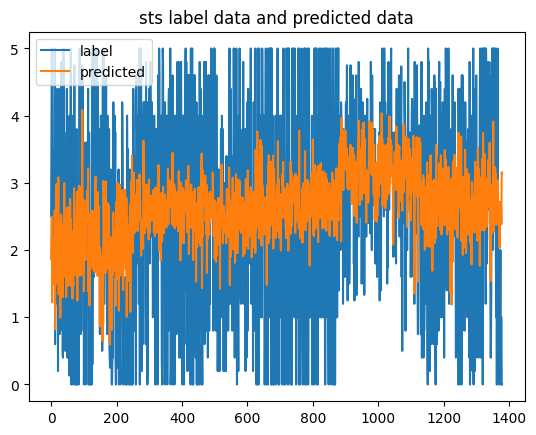

In [12]:
x_ax = range(len(test_label))
plt.plot(x_ax, test_label, label="label")
plt.plot(x_ax, test_predict, label="predicted")
plt.title("sts label data and predicted data")
plt.legend()
plt.show()